In [1]:
import pathlib, sys, os, random, time
import torch
torch.cuda.empty_cache()
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# mounting google drive
collaboratory = False

if collaboratory:
    from google.colab import drive
    drive.mount('/gdrive')
    # !ln -s "/gdrive/Shareddrives/HSC_project/HSC_ML" "/content/HSC_ML"
    os.chdir("/gdrive/Shareddrives/HSC_project/HSC_ML")
else: 
    print('Running on local systems, if running on collaboratory please change above')

print(os.listdir())
# print(os.getcwd())
#!unzip ./HSC_ML/Output/TBCells_crops.zip -d ./HSC_ML/Output/

if collaboratory:
  image_folder = "./Output/"
else:
  image_folder = "../../Output/TBCells_crops/Train_data/"
trained_weights = image_folder[:-11]+"Results/Latest_Weight_AE_unet/"


if not os.path.exists(trained_weights):
        os.makedirs(trained_weights)

Running on local systems, if running on collaboratory please change above
['Note.txt', 'test copy.ipynb', 'CNN_training.ipynb', 'CNN_auto_encoder.ipynb', 'delete-files.py', 'Resnet_training.ipynb', 'CNN_training_test.ipynb', 'CNN_auto_encoder_backup.ipynb']


# Elastic deformation

In [3]:

# pip install git+https://github.com/gvtulder/elasticdeform

import numpy, imageio, elasticdeform
from matplotlib import image

augmented_data_req = False

if augmented_data_req:
    augmented_images = os.path.abspath(os.path.join(image_folder, os.pardir)) + "/augmented_images/"

    if not os.path.exists(augmented_images):
            os.makedirs(augmented_images)
            

    for folder in os.listdir(image_folder):
        current_folder = os.path.join(image_folder, folder)
        augmented_folder = augmented_images + folder + "/"
        
        if not os.path.exists(augmented_folder):
            os.makedirs(augmented_folder)
        for image_name in os.listdir(current_folder):
            current_image = os.path.join(current_folder,  image_name)
            # apply deformation with a random 3 x 3 grid
            my_image = np.array(image.imread(current_image))
            images_deformed = elasticdeform.deform_random_grid(my_image, sigma=3, points=2)
            imageio.imsave( augmented_folder + image_name.split(".")[0] + "_aug.tif", images_deformed)
    



In [4]:
# copy generated images

copy_augmented_data = False
if copy_augmented_data:
    import shutil
    for folder in os.listdir(image_folder):
        current_folder = os.path.join(image_folder, folder)
        augmented_folder = augmented_images + folder + "/"
        for image_name in os.listdir(augmented_folder):
            current_image = os.path.join(augmented_folder,  image_name)
            shutil.copy(current_image, current_folder)

# spliting dataset into train and test

In [5]:
train_transform = transforms.Compose([
    #transforms.Resize((64,64)),
    transforms.Resize((572,572)),
    transforms.ColorJitter(brightness = 0.25, contrast=0.25),
    #transforms.RandomRotation(90),
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.RandomRotation(degrees=(270, 270)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([transforms.Resize((572,572)),transforms.ToTensor()])

In [6]:
import torch
from torchvision import datasets

# add path of images https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [7]:
import sklearn.model_selection


dataset = ImageFolderWithPaths(image_folder, transform=train_transform)
print(dataset.class_to_idx)
train_indices, val_indices = sklearn.model_selection.train_test_split(
                    list(range(dataset.__len__())),          # list of indices of dataset
                    stratify = dataset.targets,                 # for stratify sampling the data due to the unblanced dataset
                    random_state = 42,
                    test_size=.25                               #represent the proportion of the dataset to include in the train split.
                    )



# subsetting the dataset into train and test
training_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, val_indices) 

print(f"Length of dataset:" )
print(f" {'Train dataset':<12}   \u2502   {'Test data':>12} ")
print(f" {len(training_data):<12}    \u2502   {len(test_data) :>12}")



{'BCells_Old_crops': 0, 'TCells_Old_crops': 1}
Length of dataset:
 Train dataset   │      Test data 
 49116           │          16372


# Iterating and Visualizing the Dataset

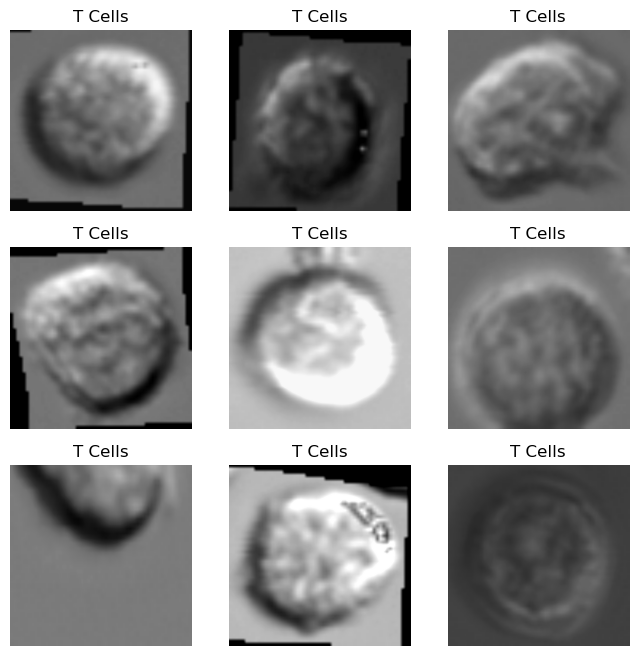

In [8]:
labels_map = {
    0: "B Cells",
    1: "T Cells",
    #2: "T8 Cells",

}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray") 
plt.show()

In [9]:

batch_size = 16

# setting sampler weight
y_train_indices = training_data.indices
y_train = [dataset.targets[i] for i in y_train_indices]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True) 


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size= batch_size,sampler = sampler, pin_memory=True, )
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

for X, y, _ in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([16, 3, 572, 572])
Shape of y:  torch.Size([16]) torch.int64


# Training the model

In [10]:
def enc_block(in_features, out_features, kernel_size=3, padding=1):
            """ run 1 block of convolution  
            
            """
            block = nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=3, padding=1),
                nn.LeakyReLU(),
                nn.BatchNorm2d(out_features),
                
            )
            # mx_pool = nn.MaxPool2d(2, stride=2, return_indices=True)
            return block
        
def dec_block(in_features, out_features, kernel_size=3, padding=1):
            """ run 1 block of convolution  
            
            """
            block = nn.Sequential(
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, padding=1),
                nn.LeakyReLU(),
                nn.BatchNorm2d(out_features),
                
            )
            # mx_pool = nn.MaxPool2d(2, stride=2, return_indices=True)
            return block
        
def print_shape(block_type, x):
    return print(f' {block_type} with shape: {x.size()}')

In [11]:

class CNN_encoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        
        self.encoder_1 = enc_block(in_features, 16, kernel_size=3, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_2 = enc_block(16, 32, kernel_size=3, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_3 = enc_block(32, 64, kernel_size=3, padding=1)
        self.encoder_pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_lin = nn.Sequential(   
            nn.Flatten(start_dim=1, ),
            #each Maxpool make the images into half. 
            # so after the Maxpool image size become 64 ==> 32 ==>16 ==> 8
            nn.Linear(8*8*64, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
 

    def forward(self, x):
        x            = self.encoder_1(x)
        x, indices_1 = self.encoder_pool1(x)
        x            = self.encoder_2(x)
        x, indices_2 = self.encoder_pool2(x)
        x            = self.encoder_3(x)
        x, indices_3 = self.encoder_pool3(x)
        x            = self.encoder_lin(x)
        return x, indices_1, indices_2, indices_3



class CNN_decoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(n_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 8*8*64),
            nn.ReLU(),
            nn.Unflatten(1, unflattened_size= (64, 8, 8))
        )
        
        self.mx_pool_1 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_1 = dec_block(64, 32, kernel_size=3, padding=1)
        
        self.mx_pool_2 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_2 = dec_block(32, 16, kernel_size=3, padding=1)
        
        self.mx_pool_3 = nn.MaxUnpool2d(2, stride=2)
        self.decoder_3 = dec_block(16, in_features, kernel_size=3, padding=1)
        
        


    def forward(self, x, indices_1, indices_2, indices_3):

        x  = self.decoder_lin(x)
        x  = self.mx_pool_1 (x,  indices_3)
        x  = self.decoder_1(x)
        x  = self.mx_pool_2 (x,  indices_2)
        x  = self.decoder_2(x)
        x  = self.mx_pool_3 (x,  indices_1)
        x  = self.decoder_3(x)
        return x
    
    
    
class CNN_AE(nn.Module):
    
    def __init__(self, in_channels=3, n_classes=50, *args, **kwargs):
        super().__init__()
        self.encoder = CNN_encoder(in_channels, n_classes = 50, *args, **kwargs)
        self.decoder = CNN_decoder(in_channels, n_classes = 50, *args, **kwargs)
        
    def forward(self, x):
        x, indices_1, indices_2, indices_3 = self.encoder(x)
        x = self.decoder(x, indices_1, indices_2, indices_3)
        return x

In [12]:
class CNN_encoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        
        self.encoder_1 = enc_block(in_features, 16, kernel_size=3, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_2 = enc_block(16, 32, kernel_size=3, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_3 = enc_block(32, 64, kernel_size=3, padding=1)
        self.encoder_pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.encoder_lin = nn.Sequential(   
            nn.Flatten(start_dim=1, ),
            #each Maxpool make the images into half. 
            # so after the Maxpool image size become 64 ==> 32 ==>16 ==> 8
            nn.Linear(8*8*64, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
 

    def forward(self, x):
        x            = self.encoder_1(x)
        x, indices_1 = self.encoder_pool1(x)
        x            = self.encoder_2(x)
        x, indices_2 = self.encoder_pool2(x)
        x            = self.encoder_3(x)
        x, indices_3 = self.encoder_pool3(x)
        x            = self.encoder_lin(x)
        return x, indices_1, indices_2, indices_3



class CNN_decoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(n_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 8*8*64),
            nn.ReLU(),
            nn.Unflatten(1, unflattened_size= (64, 8, 8))
        )
        
        # self.mx_pool_1 = nn.MaxUnpool2d(2, stride=2)
        self.mx_pool_1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.decoder_1 = dec_block(64, 32, kernel_size=3, padding=1)
        
        self.mx_pool_2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.decoder_2 = dec_block(32, 16, kernel_size=3, padding=1)
        
        self.mx_pool_3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.decoder_3 = dec_block(16, in_features, kernel_size=3, padding=1)
        
        


    def forward(self, x, indices_1, indices_2, indices_3):

        x  = self.decoder_lin(x)
        x  = self.mx_pool_1 (x)
        x  = self.decoder_1(x)
        x  = self.mx_pool_2 (x)
        x  = self.decoder_2(x)
        x  = self.mx_pool_3 (x)
        x  = self.decoder_3(x)
        return x
    
    
    
class CNN_AE(nn.Module):
    
    def __init__(self, in_channels=3, n_classes=50, *args, **kwargs):
        super().__init__()
        self.encoder = CNN_encoder(in_channels, n_classes = 50, *args, **kwargs)
        self.decoder = CNN_decoder(in_channels, n_classes = 50, *args, **kwargs)
        
    def forward(self, x):
        x, indices_1, indices_2, indices_3 = self.encoder(x)
        x = self.decoder(x, indices_1, indices_2, indices_3)
        return x

In [13]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [14]:
# defining the model

import torchvision.models as models
from torchsummary import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Cuda acceleration enabled!" if torch.cuda.is_available() else 'Running on CPU')



def get_model(model_saved_path=None, input_shape = None):
    # initializing model
    model = UNet()
    if model_saved_path:
        print("loading Model from saved weight")
        model.load_state_dict(torch.load(model_saved_path))
        model.eval()
        
    else:
        model.eval()
        print("Building Model from scratch")
        
    if input_shape:
        print(summary(model, input_shape))
    
    # using gpu
    model = model.cuda() if torch.cuda.is_available() else model
    return model


@torch.no_grad()
def validation(model, train_dataloader, loss_fn):
    losses = []
    model.eval()
    for image, __, _ in train_dataloader:
        image = image.to(DEVICE)
        image_croped   = torchvision.transforms.CenterCrop([388, 388])(image)
        output = model(image)
        loss = loss_fn(output, image_croped)
        losses.append(loss.item())
        
    return np.array(losses).mean()


def loss_fn(y_pred, y_true):
    bce_fn = nn.MSELoss()
    loss = bce_fn(y_pred, y_true)
    return loss


### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m | Save status
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}' + '\t' + '\u2502 {}'


Cuda acceleration enabled!


In [15]:
# loading the model

trained_model_PATH = trained_weights +'TBCells.pt'
model = get_model(input_shape=(3, 572, 572))

model.to(DEVICE)

learning_rate = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr = 0.000001)

Building Model from scratch
Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 64, 568, 568]        --
|    └─ModuleList: 2                     []                        --
|    |    └─Block: 3-1                   [-1, 64, 568, 568]        38,720
|    └─MaxPool2d: 2-1                    [-1, 64, 284, 284]        --
|    └─ModuleList: 2                     []                        --
|    |    └─Block: 3-2                   [-1, 128, 280, 280]       221,440
|    └─MaxPool2d: 2-2                    [-1, 128, 140, 140]       --
|    └─ModuleList: 2                     []                        --
|    |    └─Block: 3-3                   [-1, 256, 136, 136]       885,248
|    └─MaxPool2d: 2-3                    [-1, 256, 68, 68]         --
|    └─ModuleList: 2                     []                        --
|    |    └─Block: 3-4                   [-1, 512, 64, 64]         3,539,968
|    └─MaxPool2d: 2-4               

In [16]:
# ploting validation vs train error

def loss_plot(batch_losses,vlosses):
    fig, ax = plt.subplots(1, 1, figsize = (9, 5))

    plt.title("Train-Validation Accuracy")
    plt.plot(batch_losses, label='train')
    plt.plot(vlosses, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    ax.legend(loc='best')
    fig.tight_layout()
    plt.savefig(trained_weights + "Train_Validation_Accuracy.png", bbox_inches='tight', dpi=150)
    plt.close()

In [17]:
EPOCHES = 350
vloss_min = np.Inf
print(header)
batch_losses = []
vlosses = []

for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, __, _ in train_dataloader:
        # 64 = image shape
        image = image.to(DEVICE)
        optimizer.zero_grad()
        # print(image.size())
        output = model(image)
        image_croped   = torchvision.transforms.CenterCrop([388, 388])(image)
        loss = loss_fn(output, image_croped)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    vloss = validation(model, test_dataloader, loss_fn)
    
    batch_loss = np.array(losses).mean()
    batch_losses.append(batch_loss)
    
    vlosses.append(vloss)
    if vloss_min > vloss:
        vloss_min = vloss
        torch.save(model.state_dict(), trained_weights +'TBCells.pt')
        save_status = 'Yes'
        loss_plot(batch_losses,vlosses)
    else:
        save_status = 'No'
        
    print(raw_line.format(epoch, batch_loss, vloss,
                              (time.time()-start_time)/60**1, save_status))


        Train | Valid
Epoch |  Loss |  Loss | Time, m | Save status



OutOfMemoryError: CUDA out of memory. Tried to allocate 1.17 GiB (GPU 0; 10.91 GiB total capacity; 9.26 GiB already allocated; 176.81 MiB free; 9.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [18]:
!nvidia-smi


Wed Feb 22 19:37:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0  On |                  N/A |
| 73%   70C    P5    21W / 280W |  10993MiB / 11264MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   

In [ ]:
!sudo kill -9 1127081

# Reconstruct model from saved weights

In [ ]:
restart = False
if restart:
    model1 = torchvision.models.resnet50()
    model1.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=2048,
            out_features=1
        ),
        torch.nn.Sigmoid()
    )
    model1.load_state_dict(torch.load(trained_weights +'TBCells.pt'))

# Evaluating results

In [ ]:

# validating dataset

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import shutil

# defining hook to access output from intermidiate layer
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# registerning the hook. different layer can be accessed by changing
# fc[3] parameter. for details 
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html

# print(model)
model.decoder[0].register_forward_hook(get_features('feats'))


trained_model_PATH = trained_weights +'TBCells.pt'
model.load_state_dict(torch.load(trained_model_PATH))
model.eval()


y_pred = []
y_true = []
FEATS = [] # extracted feats will be saved here
# placeholder for batch features
features = {}


with torch.no_grad():
    for image, target, path in test_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        outputs = model(image)
        output = (torch.max(outputs, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        target = target.data.cpu().numpy()
        
        # not_matched = [target.index(y) for x, y in zip(y_pred, target) if y != x]
        not_matched = np.where(y_pred != target)[0]
        if not os.path.exists(trained_weights + "wrong_pred/"):
            os.makedirs(trained_weights + "wrong_pred/")
            for element in not_matched:
                shutil.copy(path[element], trained_weights + "wrong_pred/" + path[element].split("/")[-1]) 
        y_true.extend(target) # Save Truth
        FEATS.extend((features['feats'].cpu().numpy())) # Save feature
       
print(f' Feature extracted with shape: {np.array(FEATS).shape}')

In [ ]:
classes = labels_map.values()   
 
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

class_accuracy=np.mean(100*cf_matrix.diagonal()/cf_matrix.sum(1))
print(f'average acuraccy of all classes: {class_accuracy}')

# ploting 
font = {'family' : 'Arial',
        'size'   : 20}

plt.rc('font', **font)
fig, ax = plt.subplots( dpi = 150)
sn.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')
ax.set_title(f'Confusion Matrix, average acuracy: {class_accuracy :.2f}', fontsize = 15)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.xlabel('Predicted'); plt.ylabel('True');

plt.savefig(trained_weights + 'cf_matrix.png', bbox_inches='tight')

In [ ]:
# classification report

from sklearn.metrics import classification_report
import seaborn as sns

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df = pd.DataFrame(cls_report)
# df.drop(columns=['accuracy'])

fig, ax = plt.subplots(1, 1, figsize = (9, 5))

sns.heatmap(df.iloc[:-1, :].T, annot=True)
fig.tight_layout()
plt.savefig(trained_weights + "classification_report.png", bbox_inches='tight', dpi=150)

In [ ]:
print(np.array(FEATS).shape)

In [ ]:
# T-SNE plot

from sklearn.manifold import TSNE
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=0, perplexity=50, n_iter=5000)
tsne_proj = tsne.fit_transform(FEATS)
# Plot those points as a scatter plot and label them based on the pred labels

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for lab in range(len(labels_map)):
    indices = np.array(y_pred)==lab
    #ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.savefig(trained_weights + "T-SNE.png", bbox_inches='tight', dpi=150)

In [ ]:
#pip install keyboard
#import keyboard
#keyboard.press_and_release('command+s')

nb_name = "test.ipynb"
nb_full_path = os.path.join(os.getcwd(), nb_name)

import shutil
shutil.copyfile(nb_full_path, trained_weights  + nb_name)
